Ejercicio del set de imágenes CIFAR10- Clasificando imágenes diversas

- TENSORFLOW parte 1- Pre-Procesamiento de datos
- Andrés de la Rosa
- En este caso se utilizaron las imágenes CIFAR10 del sitio original, a estas imágenes que vienen
en 5 batches  se le realizó un procesamiento que queda definido en las funciones de este
notebook 

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [9]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

El Data set Original viene del tamano 10,000 X 3072
El modelo toma los datos de la forma  (ancho X alto X Numero de Canales),  Por lo que se deben hacer las transformaciones de lugar para alimentarlo
- 10,000 X 1024 X 3 - Lo transformamos con 3 channels porque las fotos estan a color 
- 10,000 X 32 X 32 X 3 - lo transformamos al tamano 32 X 32 pixeles 


In [10]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [11]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.imshow(sample_image)


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

Example of Image 2500:
Image - Min Value: 25 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


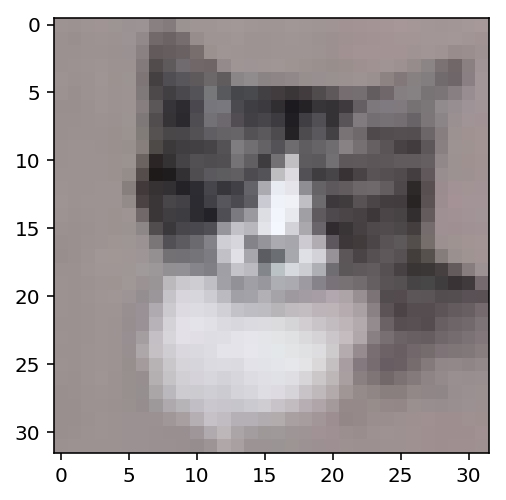

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 2
sample_id = 2500
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [13]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [14]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [15]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [16]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))